#Final Team Project: Music Genre and Composer Classification Using Deep Learning

#Pre-Processing

In [2]:
pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 59.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.4 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=a64528146bbf37c40844d1960ffe463460d3529bebe8329f196602e815857e33
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [3]:
pip install tensorflow

In [4]:
import os
import shutil
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pretty_midi
import random
import json
import joblib


from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.ops.math_ops import NotEqual
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Bidirectional,Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Masking

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.regularizers import l2

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
set_seed(42)

os.environ['TF_DETERMINISTIC_OPS'] = '1'

import warnings
warnings.filterwarnings("ignore")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd drive/MyDrive/Masters_AI/6-Neural Networks and Deep Learning/Project/

/content/drive/MyDrive/Masters_AI/6-Neural Networks and Deep Learning/Project


In [7]:
#Extracted features from midi files and stored in .csv
#Extracted freatures are[composer, file, instrument, start, end, duration, velocity]

df = pd.read_csv('full_midi_features.csv')
df.sample(10, random_state=42)

,composer,file,instrument,pitch,start,end,duration,velocity,pitch_bends,control_changes,note_density,polyphony,chord_density,time_signature,tempo
494503,Mozart,K136 Divertimento 1mov_1.mid,Unknown,62,63.333270,63.571365,0.238095,88,0,3,3.024537,3.024537,0.935849,4/4,114.800100
3918022,Beethoven,Piano Sonata n29 Op106 ''Hammerklavier''.mid,Right Hand Outer,85,740.854391,740.959301,0.104910,127,0,288,4.161895,4.161895,0.959355,2/2,105.210517
5317414,Bach,Bwv1058 Harpsichord Concerto n7 1mov.mid,Cembalo obbligato,50,32.550000,32.675000,0.125000,96,0,0,4.112524,4.112524,0.942203,2/4,100.000000
6434285,Bach,Bwv0528 Sonate en trio n4.mid,Track 1,69,420.208373,420.603110,0.394737,92,0,0,2.567024,2.567024,0.986216,4/4,48.937513
4715296,Bach,Bwv0565 Toccata and Fugue In Dm A_1.mid,Sup. Strings,38,19.636344,32.693149,13.056805,89,0,2,2.431279,2.431279,0.865740,4/4,110.000110
4330262,Chopin,Etude op10 n01_1.mid,Piano right,98,74.186572,74.276662,0.090090,96,0,2,4.265073,4.265073,1.000000,4/4,167.413523
5560970,Bach,Bwv1068 Orchestral Suite n3 3mov.mid,Oboe I,68,215.421231,215.810119,0.388888,76,0,3,3.600153,3.600153,0.945387,2/4,125.299099
4830991,Bach,"Tocatto No.1 in F Sharp Minor, BWV 910_1.mid",Unknown,78,209.231907,209.408618,0.176711,100,1,2,5.330564,5.330564,0.989413,4/4,77.999999
43126,Mozart,K354 Piano Variations ''Je Suis Lindor''.mid,MIDI by Marty Weimer 10/25/95,62,428.734605,429.001272,0.266667,80,0,2,2.474579,2.474579,0.916410,2/4,96.379313
266915,Mozart,K626 Requiem kyrie.mid,fg,62,17.512500,17.590625,0.078125,79,0,3,3.458209,3.458209,0.914055,4/4,45.583334


In [8]:
#We have total 6807702 rows and 8 columns

df.shape

(6565740, 15)

In [9]:
#unique counts for each composer[Bach, Beethoven, Mozart, Chopin]
#It is a imbalanced dataset- need to handle

df['composer'].value_counts()

,count
composer,
Beethoven,2271432
Bach,1926775
Mozart,1728127
Chopin,639406


In [10]:
#Features for each midi file
#'composer' is a target variable(label)

df.columns

Index(['composer', 'file', 'instrument', 'pitch', 'start', 'end', 'duration',
       'velocity', 'pitch_bends', 'control_changes', 'note_density',
       'polyphony', 'chord_density', 'time_signature', 'tempo'],
      dtype='object')






# Data Cleaning

In [11]:
#Instrument column has NAN

df.isnull().sum()

,0
composer,0
file,0
instrument,0
pitch,0
start,0
end,0
duration,0
velocity,0
pitch_bends,0
control_changes,0


In [12]:
# Check for duplicate rows across all columns
duplicate_rows = df[df.duplicated(keep=False)]

# Display duplicate rows
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
duplicate_rows.head()


Number of duplicate rows: 207519


,composer,file,instrument,pitch,start,end,duration,velocity,pitch_bends,control_changes,note_density,polyphony,chord_density,time_signature,tempo
2298,Mozart,K622 Clarinet Concerto 2mov.mid,KV622B11,62,112.129167,113.329167,1.2,80,0,4,4.750225,4.750225,0.991791,3/4,85.0
2372,Mozart,K622 Clarinet Concerto 2mov.mid,KV622B11,62,49.729167,50.929167,1.2,80,0,4,4.750225,4.750225,0.991791,3/4,85.0
2394,Mozart,K622 Clarinet Concerto 2mov.mid,KV622B11,62,112.129167,113.329167,1.2,80,0,4,4.750225,4.750225,0.991791,3/4,85.0
2409,Mozart,K622 Clarinet Concerto 2mov.mid,KV622B11,57,294.529167,295.729167,1.2,80,0,4,4.750225,4.750225,0.991791,3/4,85.0
2414,Mozart,K622 Clarinet Concerto 2mov.mid,KV622B11,62,299.329167,300.529167,1.2,80,0,4,4.750225,4.750225,0.991791,3/4,85.0


In [13]:
duplicates = df[df.duplicated(keep=False)]
duplicates.sort_values(by='composer').head(15)

,composer,file,instrument,pitch,start,end,duration,velocity,pitch_bends,control_changes,note_density,polyphony,chord_density,time_signature,tempo
6525301,Bach,Bwv0539 Prelude and Fugue_1.mid,J.S. Bach BWV 539,55,223.988046,224.254713,0.266667,127,0,0,2.491506,2.491506,0.906442,4/4,81.399996
5058278,Bach,024842b4.mid,Instrument 6,74,38.863626,39.204535,0.340909,96,0,0,4.531181,4.531181,1.000000,3/4,88.000023
5058277,Bach,024842b4.mid,Instrument 6,74,38.863626,39.204535,0.340909,96,0,0,4.531181,4.531181,1.000000,3/4,88.000023
5058276,Bach,024842b4.mid,Instrument 6,74,38.522717,38.863626,0.340909,96,0,0,4.531181,4.531181,1.000000,3/4,88.000023
5058275,Bach,024842b4.mid,Instrument 6,74,38.522717,38.863626,0.340909,96,0,0,4.531181,4.531181,1.000000,3/4,88.000023
5058274,Bach,024842b4.mid,Instrument 6,81,38.181808,38.522717,0.340909,96,0,0,4.531181,4.531181,1.000000,3/4,88.000023
5058273,Bach,024842b4.mid,Instrument 6,81,38.181808,38.522717,0.340909,96,0,0,4.531181,4.531181,1.000000,3/4,88.000023
5058272,Bach,024842b4.mid,Instrument 6,79,38.011353,38.181808,0.170454,96,0,0,4.531181,4.531181,1.000000,3/4,88.000023
5058271,Bach,024842b4.mid,Instrument 6,79,38.011353,38.181808,0.170454,96,0,0,4.531181,4.531181,1.000000,3/4,88.000023
5058270,Bach,024842b4.mid,Instrument 6,81,37.840899,38.011353,0.170455,96,0,0,4.531181,4.531181,1.000000,3/4,88.000023


In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df.shape

(6456428, 15)

In [16]:
#Dataset is imbalanced-music notes for Beethoven, Bach, Mozart and Chopin are imbalanced
#Minority class is Chopin and we will go for downsampling since the dataset is large and downsampling would be best fit
df['composer'].value_counts()

,count
composer,
Beethoven,2265358
Bach,1892450
Mozart,1659342
Chopin,639278


In [17]:
# Find the minimum class size (we already know it's Chopin)
min_count = df['composer'].value_counts().min()

# Downsample each class to match the smallest class
df_balanced = (
    df.groupby('composer')
      .apply(lambda x: x.sample(n=min_count, random_state=42))
      .reset_index(drop=True)
)

# Check class balance
print(df_balanced['composer'].value_counts())

# Optional: Save balanced dataset
df_balanced.to_csv('composer_data_balanced.csv', index=False)


composer
Bach         639278
Beethoven    639278
Chopin       639278
Mozart       639278
Name: count, dtype: int64


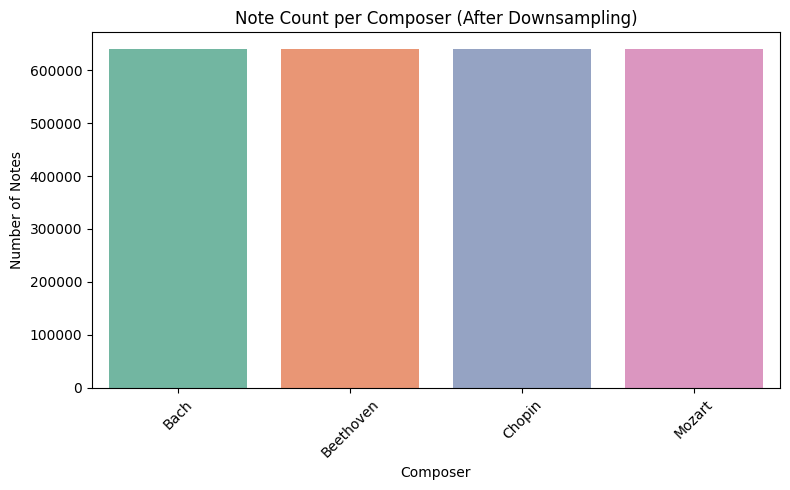

In [18]:
#Visulaize for balanced dataset
# Count note entries per composer
composer_counts = df_balanced['composer'].value_counts()

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=composer_counts.index, y=composer_counts.values, palette="Set2")
plt.title("Note Count per Composer (After Downsampling)")
plt.xlabel("Composer")
plt.ylabel("Number of Notes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [19]:
df_balanced.columns

Index(['composer', 'file', 'instrument', 'pitch', 'start', 'end', 'duration',
       'velocity', 'pitch_bends', 'control_changes', 'note_density',
       'polyphony', 'chord_density', 'time_signature', 'tempo'],
      dtype='object')

# Feature Selection

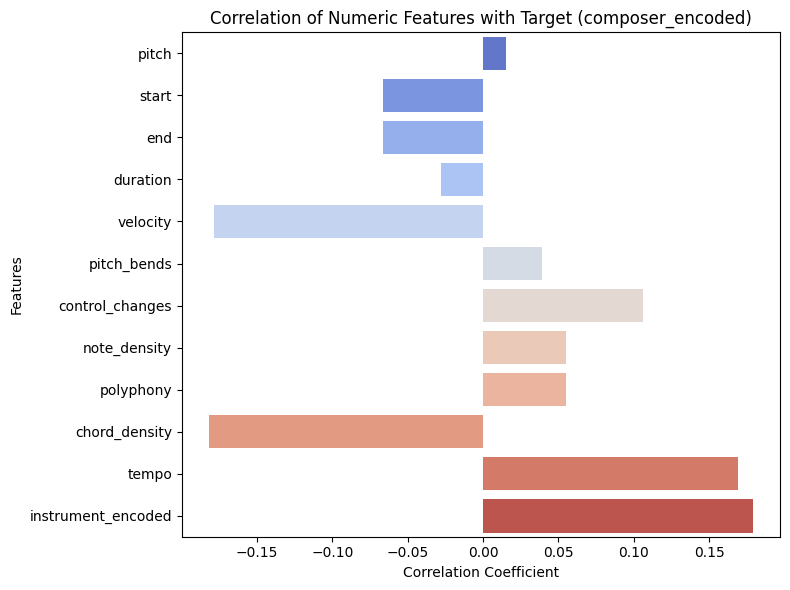

In [20]:
# Drop non-numeric columns for correlation (or encode if needed)
data_bal = df_balanced.copy()

le = LabelEncoder()
data_bal['composer_encoded'] = le.fit_transform(data_bal['composer'])

# Encode instrument to numeric if it's not yet
if data_bal['instrument'].dtype == 'object':
    data_bal['instrument_encoded'] = le.fit_transform(data_bal['instrument'])

# Select only numeric columns
numeric_cols = data_bal.select_dtypes(include=['int64', 'float64']).columns

# Compute correlation of each feature with composer_encoded
target_corr = data_bal[numeric_cols].corr()['composer_encoded'].drop('composer_encoded')

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')
plt.title('Correlation of Numeric Features with Target (composer_encoded)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


# Descriptive Analysis:composer vs feature

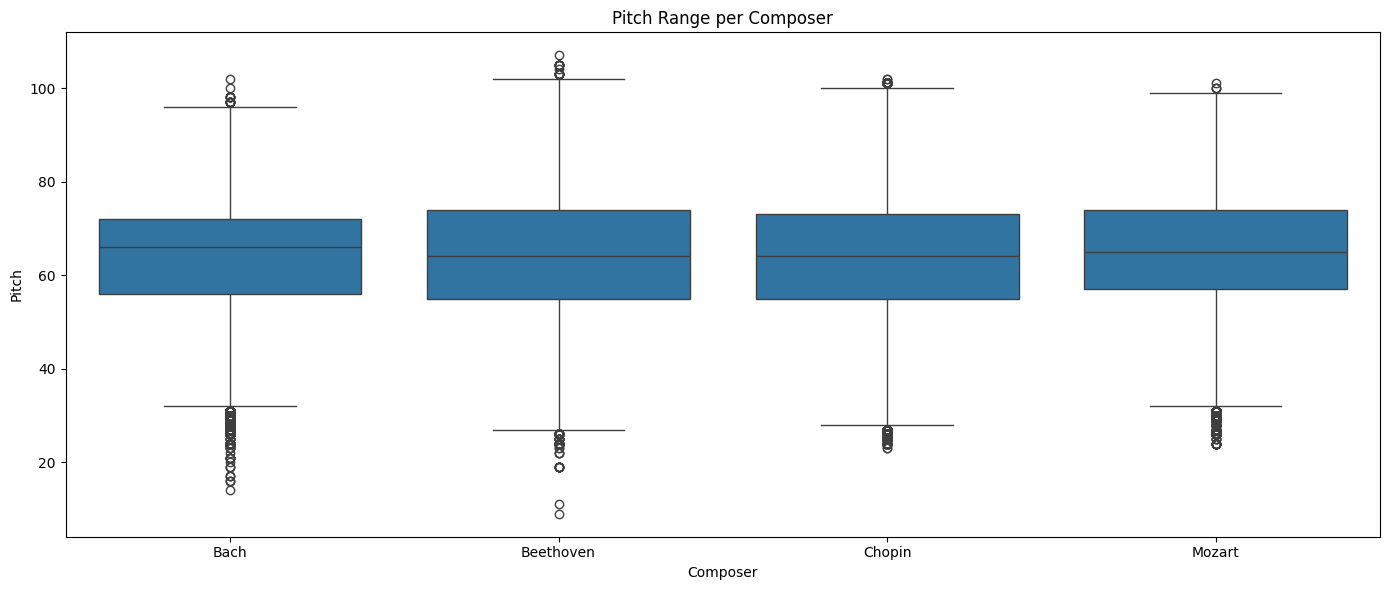

In [21]:
#I will consider features [pitch,pitch_bends,control_changes,note_density,polyphony,tempo and instrument]

#Visualise using thse above features if i can get insight about music style by all the composers

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_balanced, x='composer', y='pitch')
plt.title("Pitch Range per Composer")
plt.xlabel("Composer")
plt.ylabel("Pitch")
plt.tight_layout()
plt.show()


1. Pitch Medians (central horizontal lines):
Bach has the highest median pitch (around 68).

Beethoven, Chopin, and Mozart all have similar median pitch values (around 64-65).

➡️ This suggests Bach tended to use slightly higher pitch notes more often than the others.

2. Interquartile Ranges (IQR-box height):
All composers show similar IQRs, meaning their middle 50% of pitch values are roughly within the same range.

No one composer has a drastically narrower or wider pitch distribution within the middle 50%.

3. Outliers (dots):
All composers have significant outliers on both low and high ends.

These could be extreme low or high notes used occasionally.

➡️ However, Beethoven and Chopin show more low-pitch outliers, suggesting occasional use of very low notes more than the others.

4. Overall Pitch Ranges (whiskers):
Ranges (min to max, excluding outliers) are very similar across all composers.

This indicates no composer exclusively avoids certain pitch ranges.

-> Musical Insight
Pitch alone may not be a strong differentiator among composers.

Bach leans toward slightly higher pitches, but the overlap is large.

Might be more informative when combined with other features like duration, velocity, chord density, etc.


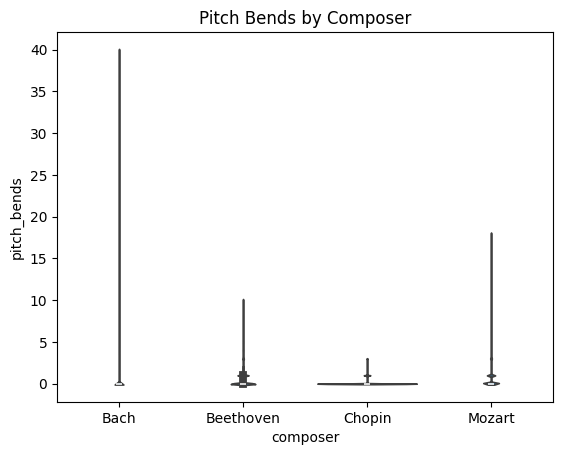

In [22]:
sns.violinplot(data=df_balanced, x='composer', y='pitch_bends')
plt.title("Pitch Bends by Composer")
plt.show()


 What is a Pitch Bend?

Pitch bends are expressive controls in MIDI music, allowing for smooth glides between notes, often used for emotion or mimicry of human voice/instruments like violin or guitar.



| Composer      | Interpretation                                                                                                                                                                                                                                           |
| ------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Bach**      | Shows the **widest range** of pitch bends (up to 40), but with many values near zero. Likely caused by **a few extreme outliers** — maybe due to **MIDI artifacts or synthesized versions**, since true Baroque compositions rarely include pitch bends. |
| **Beethoven** | Low pitch bend usage, tightly clustered near zero. Suggests **rare use of expressive pitch modulation**.                                                                                                                                                 |
| **Chopin**    | Even **less use** of pitch bends. Strong clustering around zero indicates that **Chopin’s works in your MIDI data rarely include pitch bending**, aligning with classical piano expression style.                                                        |
| **Mozart**    | Some outliers, but most values are **close to zero**. Suggests limited pitch bending overall.                                                                                                                                                            |


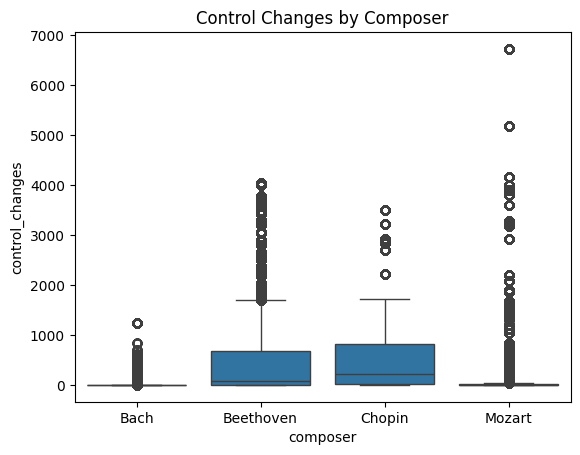

In [23]:
sns.boxplot(data=df_balanced, x='composer', y='control_changes')
plt.title("Control Changes by Composer")
plt.show()


 General Interpretation

Y-axis: Number of control changes (how frequently modulation/expressive controls like volume, sustain, etc., were used).

Each box: Represents the interquartile range (IQR) — the middle 50% of data.

Whiskers: Show the range within 1.5*IQR.

Dots (outliers): Indicate unusual or extreme control_change counts.





| Composer      | Summary                                                                                                                                                                                                                          |
| ------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Bach**      | Very few control changes. The box is compressed near zero, indicating that **Bach's pieces are less expressive in MIDI control changes** — consistent with his Baroque era style (more structured, less dynamically expressive). |
| **Beethoven** | Much higher median and wide spread. Many outliers → suggests **frequent and variable use of expressive controls**, likely reflecting Beethoven’s emotional and dynamic style.                                                    |
| **Chopin**    | Similar to Beethoven: high variability, high median. Supports the idea that **Romantic-era composers used more expressive modulations**.                                                                                         |
| **Mozart**    | Large number of outliers but a smaller IQR. Suggests that **most Mozart pieces are similar in control use**, but a few are very expressive (possibly orchestral or operatic pieces).                                             |


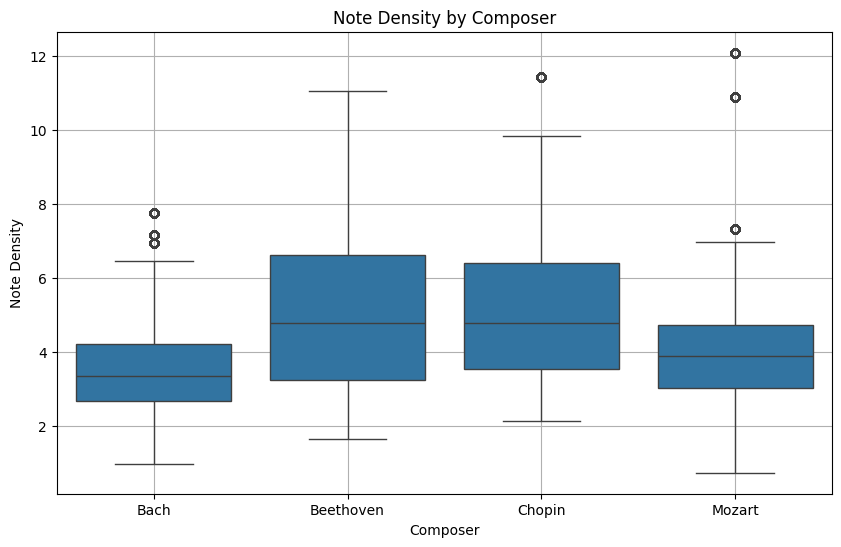

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='composer', y='note_density', data=df_balanced)
plt.title('Note Density by Composer')
plt.xlabel('Composer')
plt.ylabel('Note Density')
plt.grid(True)
plt.show()


Observations:

Beethoven and Chopin:

Have higher median note density (~5) compared to Bach and Mozart.

Their interquartile ranges (IQRs) are wider, meaning they use more varied note densities across compositions.

Some outliers suggest dense musical moments, but nothing extreme.

Bach:

Has a lower median note density (~3).

A narrower IQR suggests more consistency in how dense his music tends to be.

Few high-density outliers (~8), possibly due to sections with contrapuntal layering.

Mozart:

Median similar to Bach but with slightly more variability.

A few higher outliers (~12), which might reflect more ornamented or busy passages in some works.

Musical Insight:
Bach's consistency may reflect the structured, contrapuntal nature of Baroque music.

Beethoven and Chopin show more expressive and dynamic range, which aligns with the Romantic period's musical style.

Mozart, though Classical, shows slight overlap with Romantic complexity (outliers), but generally follows clean, moderate density patterns.

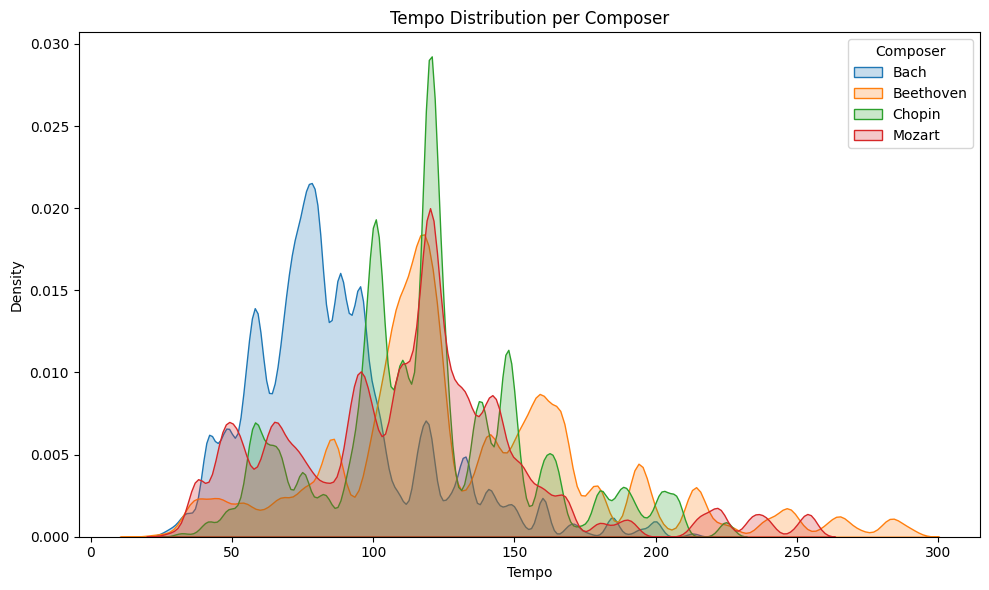

In [25]:
plt.figure(figsize=(10, 6))
for composer in df_balanced['composer'].unique():
    subset = df_balanced[df_balanced['composer'] == composer]
    sns.kdeplot(subset['tempo'], label=composer, fill=True)

plt.title('Tempo Distribution per Composer')
plt.xlabel('Tempo')
plt.ylabel('Density')
plt.legend(title='Composer')
plt.tight_layout()
plt.show()


Interpretation:

🎵 Bach

Tempo range: Mostly between 40-110 BPM.

Peak density: Around 80-90 BPM, indicating a tendency toward slower, steady tempos.

Very little high-tempo music (>140 BPM), suggesting consistency and formality in rhythm.

🎵 Beethoven

Wide range: Spans 40-260 BPM, showing highest tempo variability.

Multiple peaks: Notably around 110 BPM and 160-170 BPM, indicating dynamic contrasts (typical of the Romantic era).

Reflects expressive, dramatic compositions with both slow and fast passages.

🎵 Chopin

Peak: Sharp spike around 110-120 BPM.

Most of his tempo values lie in a narrower band, with fewer extremes.

Reflects his lyrical and expressive piano style—not too fast, not too slow.

🎵 Mozart

Moderate range: Clustered mostly around 90-130 BPM.

A smooth curve indicates evenly distributed tempos, with a slight preference for moderate speeds.

Suggests graceful, balanced compositions.

| Composer  | Style Reflected by Tempo        | Tempo Spread            | Peak Tempo (approx) |
| --------- | ------------------------------- | ----------------------- | ------------------- |
| Bach      | Structured, baroque, methodical | Narrow                  | \~80 BPM            |
| Beethoven | Expressive, dramatic            | Very wide (most varied) | \~110, 160 BPM      |
| Chopin    | Lyrical, controlled             | Narrow                  | \~110–120 BPM       |
| Mozart    | Balanced, elegant               | Moderate                | \~100–110 BPM       |


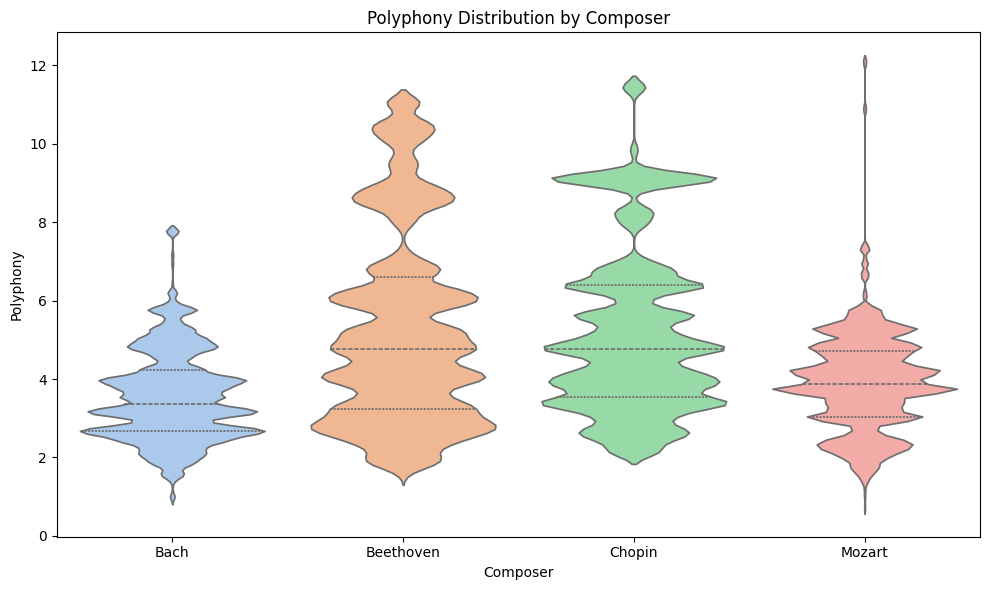

In [26]:
# Plot polyphony distribution per composer using violin + swarm for better detail
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_balanced, x="composer", y="polyphony", inner="quartile", palette="pastel")
#sns.swarmplot(data=df, x="composer", y="polyphony", size=2, color="k", alpha=0.5)
plt.title("Polyphony Distribution by Composer")
plt.ylabel("Polyphony")
plt.xlabel("Composer")
plt.tight_layout()
plt.show()


Polyphony in music refers to the number of simultaneous musical notes or voices being played at the same time. It is a key concept in music theory and analysis.

This violin plot shows the distribution of polyphony (the number of simultaneous notes or voices) for different composers: Bach, Beethoven, Chopin, and Mozart.

Key Interpretations:
1. Bach:

Most of Bach's pieces concentrate between 2 and 5 voices.

The distribution is relatively tight, suggesting consistency in polyphonic structure.

Slightly lower polyphony on average compared to the others.

2. Beethoven:

Wider distribution, suggesting more variation in the number of voices.

Median polyphony is higher than Bach’s, around 4–6.

Some compositions go up to 11–12 voices, indicating complex orchestration in parts.

3. Chopin:

Similar to Beethoven in range but more concentrated around 5–7 voices.

Shows a preference for richer textures, especially in the mid-high range.

Less low-polyphony music compared to Bach.

4. Mozart:

More balanced and symmetric distribution around 3–5.

Has the widest spread of any composer—some works with very high polyphony (~12).

Indicates a diverse style, mixing simple and complex textures.

Insights:

Bach leans toward consistent and moderate polyphony, which aligns with his contrapuntal Baroque style.

Beethoven and Chopin use richer textures, reflecting Romantic complexity.

Mozart shows great stylistic range, capable of both light textures and elaborate orchestrations.

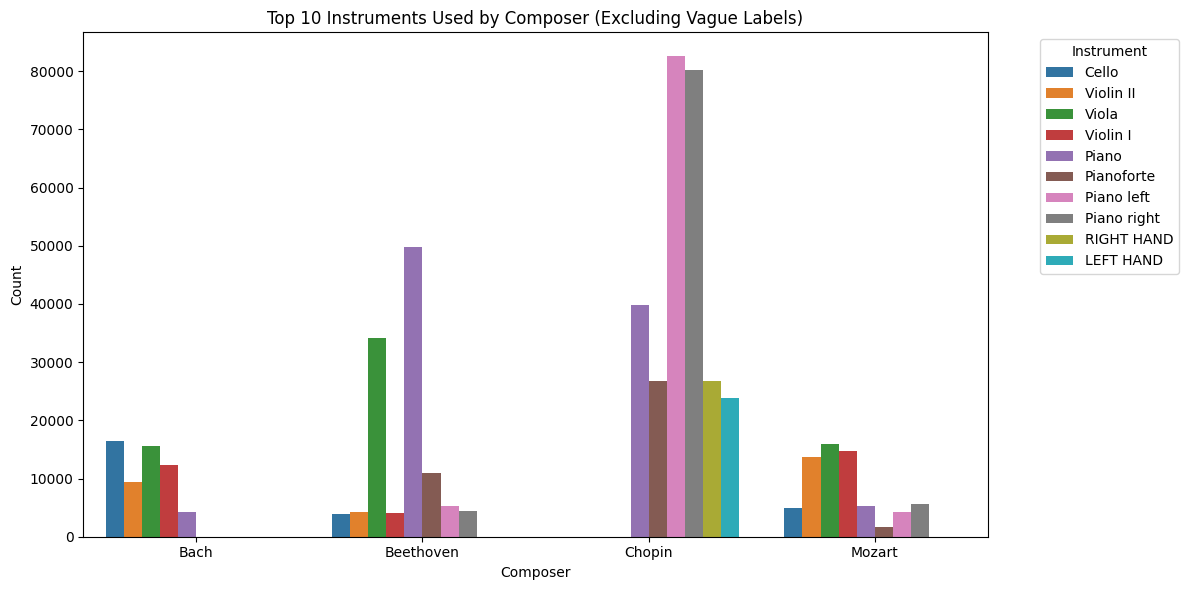

In [27]:
# Define vague instrument labels (you can adjust this list)
vague_labels = ['instrument', 'unknown', 'other', 'misc', 'unclassified', 'Instrument','No Name','Unnamed Track','Track 1','Track 2']

# Filter out vague instruments
df_filtered = df_balanced[~df_balanced['instrument'].str.lower().isin([v.lower() for v in vague_labels])]

# Select top 10 most frequent instruments from the cleaned list
top_instruments = df_filtered['instrument'].value_counts().head(10).index.tolist()

# Create new dataframe with only top 10 instruments
df_clean = df_filtered[df_filtered['instrument'].isin(top_instruments)]

# Plot: Composer vs Instrument
plt.figure(figsize=(12, 6))
sns.countplot(data=df_clean, x="composer", hue="instrument", palette="tab10")
plt.title("Top 10 Instruments Used by Composer (Excluding Vague Labels)")
plt.xlabel("Composer")
plt.ylabel("Count")
plt.legend(title="Instrument", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


 Interpretation:

🔹 Chopin

Dominates the chart in terms of note count.

Heavy use of:

Piano left and Piano right (over 80,000 notes each) → indicates use of separate MIDI tracks for left/right hands.

RIGHT HAND, LEFT HAND also appear → perhaps alternate labels for the same division.

Pianoforte and Piano also have significant note counts.

🟰 Conclusion: Chopin is almost exclusively focused on piano music.

🔹 Beethoven

Uses a mix of Piano, Pianoforte, and strings.

Piano (about 50,000 notes) is his most used instrument.

Also uses Pianoforte, Viola, and Violin I.

🟰 Conclusion: Balanced usage, leaning toward piano but still composing for strings.

🔹 Mozart

Strong use of Viola, Violin I, and Violin II → consistent with his orchestral and chamber music.

Also uses Piano and Piano left/right, but not nearly as much as Chopin.

🟰 Conclusion: More orchestral variety.

🔹 Bach

Primarily uses Viola, Cello, Violin I/II.

Minimal usage of Piano → historically accurate as the modern piano wasn't in common use in Bach’s time.

🟰 Conclusion: Bach focuses on string instruments, particularly baroque ensembles.

Overall Insights:

The instrument usage clearly reflects each composer's musical style and era:

Bach: Strings (Baroque).

Beethoven: Early piano and orchestral works (Classical transitioning to Romantic).

Chopin: Virtually all piano (Romantic solo works).

Mozart: Balanced orchestral composition (Classical).

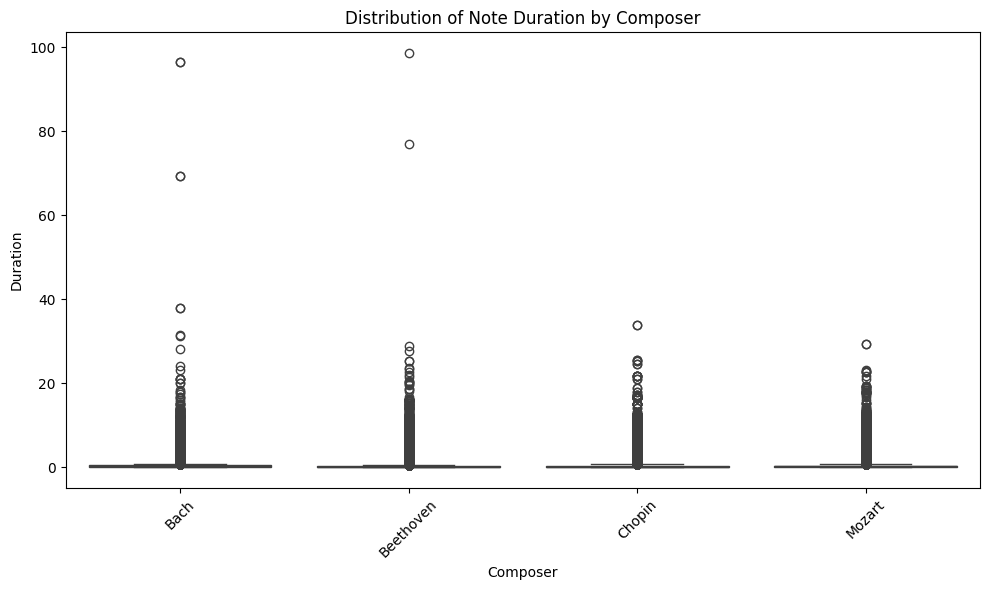

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_balanced, x='composer', y='duration')
plt.title('Distribution of Note Duration by Composer')
plt.ylabel('Duration')
plt.xlabel('Composer')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 What the Plot Shows:

All composers mostly have short note durations:

The box for each composer is very thin and near zero, showing most notes are very short.

This suggests fast passages or quick note transitions are common across composers.

Presence of Outliers:

The dots above each box represent outlier durations, i.e., unusually long notes.

For example:

Bach has outliers up to ~95

Beethoven has one exactly at 100

Chopin and Mozart also have a few extended notes

Comparative Spread:

Bach and Beethoven have the widest range of long durations, implying more note length variability in some pieces.

Mozart and Chopin tend to have fewer extreme outliers.

All composers predominantly use short-duration notes (likely fast note sequences).

Bach and Beethoven include more long sustained notes compared to Mozart and Chopin.

This could hint at stylistic differences in melodic phrasing, tempo, or instrumentation.

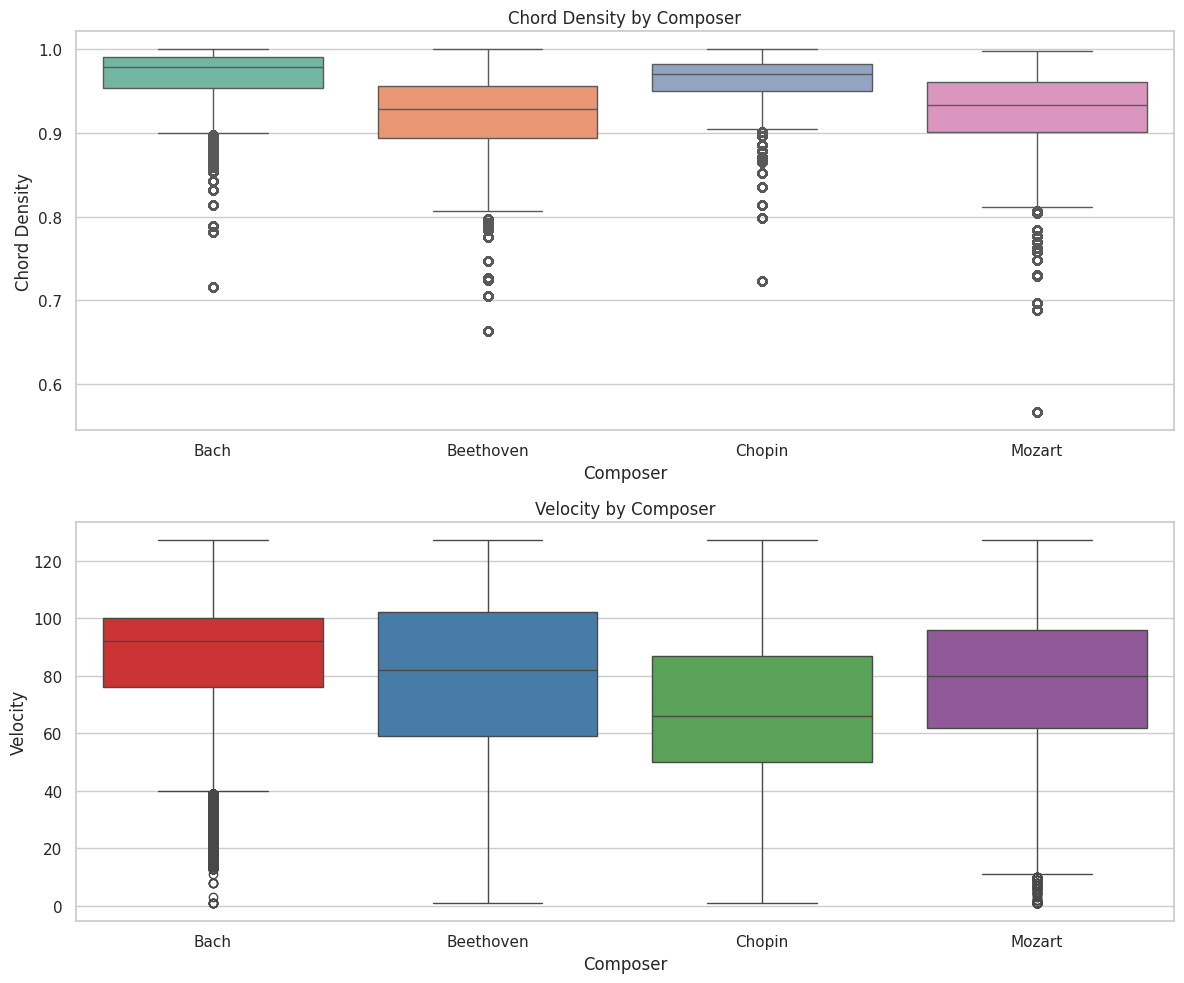

In [29]:
# Set the plot style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
palette = sns.color_palette("Set2")  # or try "pastel", "Set1", "deep", etc.

# Chord Density vs Composer
sns.boxplot(x="composer", y="chord_density", data=df_balanced, ax=axes[0], palette=palette)
axes[0].set_title("Chord Density by Composer")
axes[0].set_xlabel("Composer")
axes[0].set_ylabel("Chord Density")

palette = sns.color_palette("Set1")

# Velocity vs Composer
sns.boxplot(x="composer", y="velocity", data=df_balanced, ax=axes[1],  palette=palette)
axes[1].set_title("Velocity by Composer")
axes[1].set_xlabel("Composer")
axes[1].set_ylabel("Velocity")

plt.tight_layout()
plt.show()


 What is Chord Density?

Chord density is likely a measure of how often chords (simultaneous notes) occur in the music—possibly computed as the proportion of chord notes to total notes.

Musical Interpretation:
Bach: Shows high chord density with little variation — likely due to consistent harmonic structure (e.g., in fugues, chorales).

Chopin: Also has high density with low variability — may reflect frequent chordal textures in romantic piano works.

Beethoven: Shows more variation, possibly reflecting shifts between sparse solo lines and rich orchestration.

Mozart: Similar to Beethoven, with some compositions very rich and others relatively sparse.

| Composer      | Median Chord Density | Variability | Notes                                        |
| ------------- | -------------------- | ----------- | -------------------------------------------- |
| **Bach**      | High (\~0.98)        | Low         | Dense, consistent harmonic texture           |
| **Chopin**    | High (\~0.97)        | Low         | Romantic, chord-rich piano textures          |
| **Beethoven** | Moderate (\~0.93)    | High        | Varies between dense and sparse textures     |
| **Mozart**    | Moderate (\~0.93)    | High        | Classical balance between melody and harmony |


🎵 What is Velocity in MIDI?

In MIDI, velocity refers to how forcefully a note is played — higher velocity typically means louder or more accentuated notes.

Key Observations:

1. Median Velocity (dark line in the box):

Bach: Highest median (~92)

Mozart: Second highest (~88-90)

Beethoven: Moderate (~83)

Chopin: Lowest median (~66)

2. Spread of Velocity (IQR - the box width):

Beethoven and Mozart have the widest spread, meaning a broader dynamic range in note strength.

Chopin has a narrower spread, showing more consistency in playing strength.

3. Outliers:

All composers have outliers, mostly on the lower end (very soft notes with velocity < 30).

Bach shows many low-velocity outliers (possibly reflecting ornamentation or soft voices).

Chopin and Mozart also have soft note outliers.

4. Whiskers (Min-Max excluding outliers):

Beethoven and Chopin go all the way to 0, suggesting they include extremely soft notes.

All composers reach maximum velocity (~127), showing they all explore very loud notes too.

| Composer      | Median         | Range    | Notes                                                                    |
| ------------- | -------------- | -------- | ------------------------------------------------------------------------ |
| **Bach**      | Highest (\~92) | Narrower | Likely due to Baroque emphasis on articulation and clarity               |
| **Mozart**    | High (\~88)    | Wide     | Reflects Classical clarity with expressive extremes                      |
| **Beethoven** | Mid (\~83)     | Wide     | Romantic expression—dramatic dynamics from soft to loud                  |
| **Chopin**    | Lowest (\~66)  | Narrower | Romantic nuance — more subtle dynamics, expressive but softer on average |


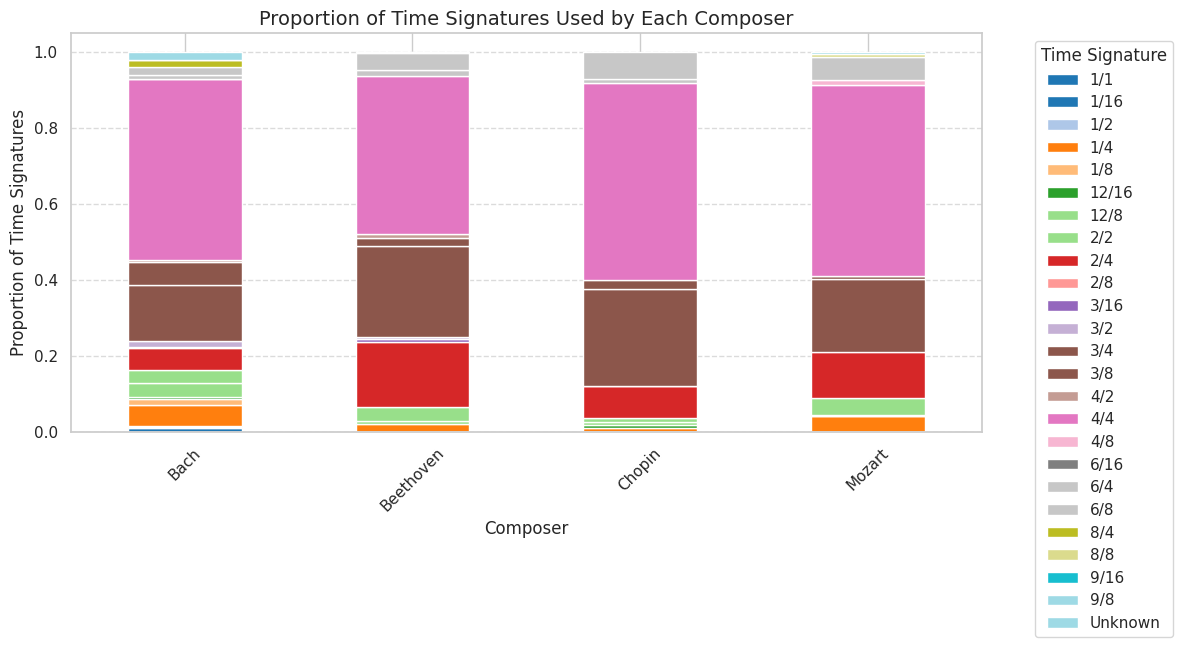

In [30]:
# Group and normalize counts
grouped = df.groupby(['composer', 'time_signature']).size().unstack(fill_value=0)

# Normalize to get proportions
grouped_normalized = grouped.div(grouped.sum(axis=1), axis=0)

# Plotting
ax = grouped_normalized.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')

# Titles and labels
plt.title('Proportion of Time Signatures Used by Each Composer', fontsize=14)
plt.xlabel('Composer', fontsize=12)
plt.ylabel('Proportion of Time Signatures', fontsize=12)
plt.legend(title='Time Signature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


X-axis: Composer names.

Y-axis: Proportion of time signatures (ranging from 0 to 1).

Each colored segment: Represents a specific time signature, such as 4/4, 3/4, etc., and the height of the segment indicates how frequently that time signature was used relative to that composer's total compositions.

Legend: Maps colors to time signatures.

Interpretation

✅ Dominant Time Signatures

4/4 (pink): Most dominant across all four composers.

Highest proportion for Bach and Chopin, showing a strong preference.

Still quite prevalent for Beethoven and Mozart.

3/8 (brown): Second-most common.

Beethoven uses it slightly more than the others.

2/4 (red): More prevalent in Beethoven and Mozart compared to Chopin and Bach.

Composer-specific Observations
Bach:

Heavy use of 4/4 and 3/8.

Shows greater diversity in rare time signatures (more thin strips).

Beethoven:

Higher use of 2/4 and 3/8 than Bach.

Slightly less reliant on 4/4 than Bach and Chopin.

Chopin:

Strongly relies on 4/4, second most on 3/8.

Very little use of other time signatures.

Mozart:

Balanced between 4/4, 3/8, and 2/4.

Slightly more variety than Chopin, but less than Bach.

| Composer      | Dominant Signature | Variety (Diversity in use) | Notes                                          |
| ------------- | ------------------ | -------------------------- | ---------------------------------------------- |
| **Bach**      | 4/4, 3/8           | High                       | Most varied usage across time signatures       |
| **Beethoven** | 4/4, 3/8, 2/4      | Medium                     | Balanced use of common signatures              |
| **Chopin**    | 4/4, 3/8           | Low                        | Heavy reliance on 4/4, minimal use of others   |
| **Mozart**    | 4/4, 3/8, 2/4      | Medium                     | Similar to Beethoven but slightly less diverse |


# Bivariate Analysis

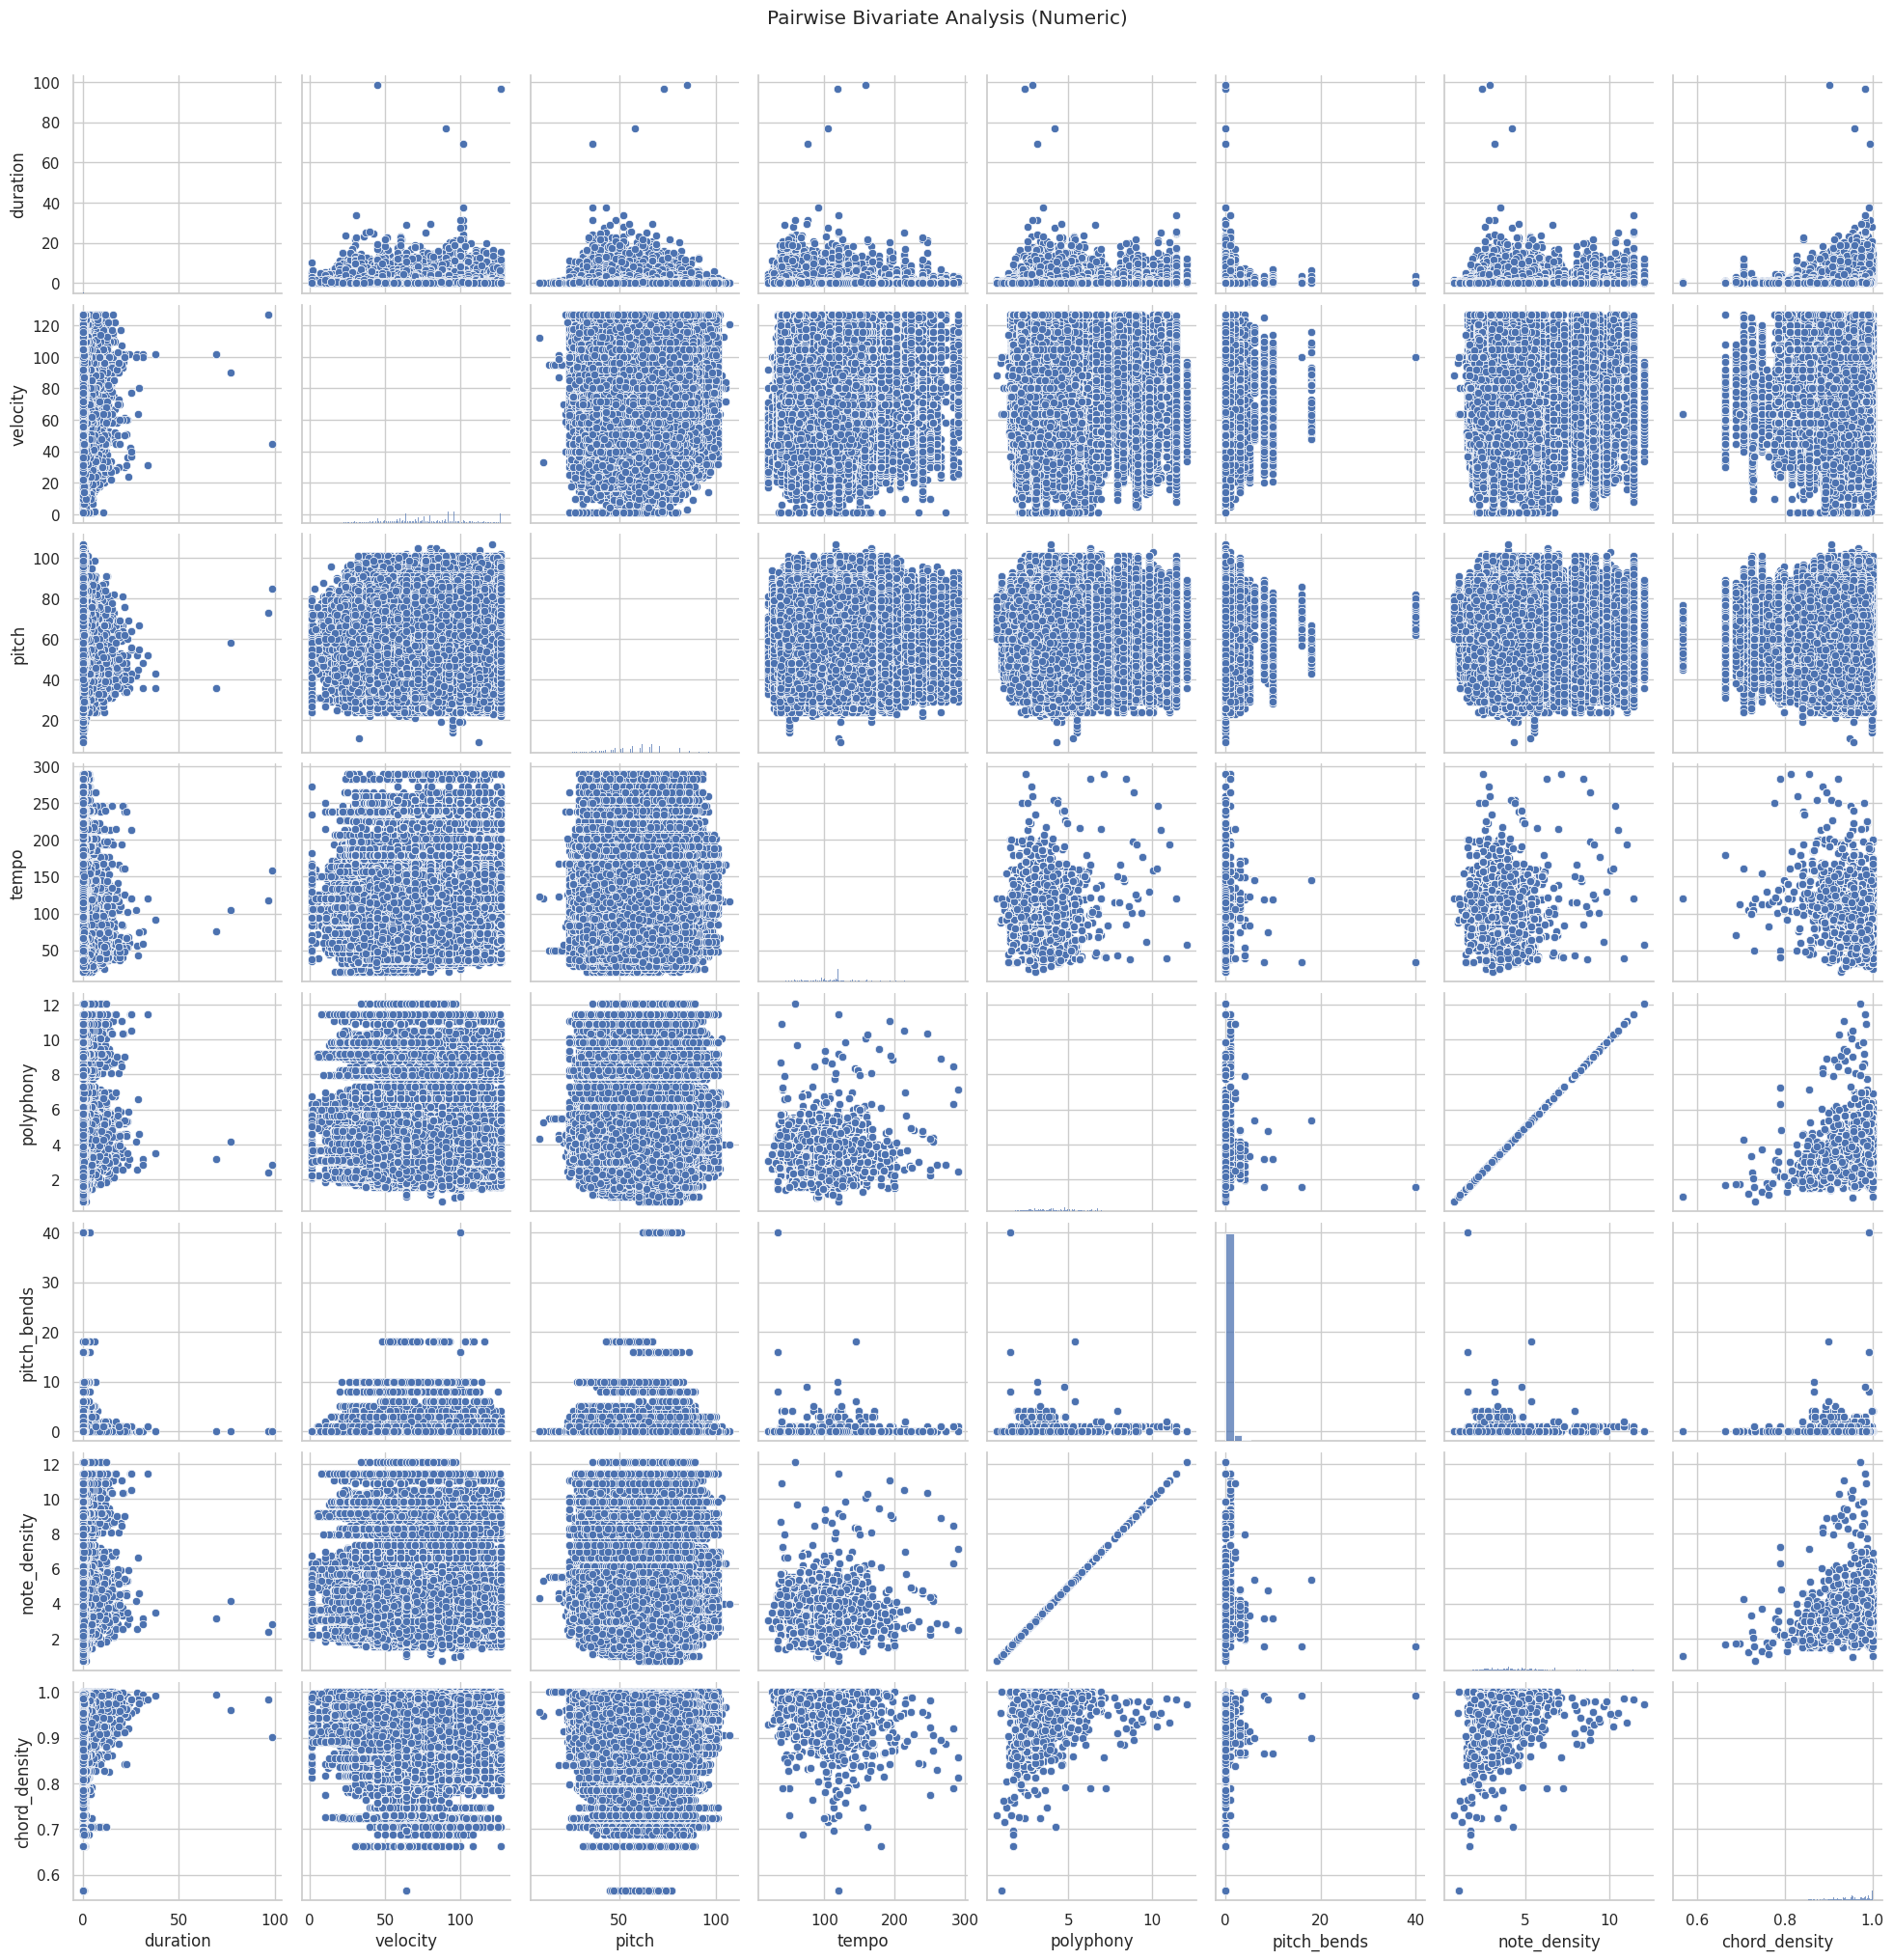

In [31]:
# Pairwise scatter + distribution plots
sns.pairplot(df_balanced[[
    'duration', 'velocity', 'pitch', 'tempo',
    'polyphony', 'pitch_bends', 'note_density', 'chord_density'
]])
plt.suptitle("Pairwise Bivariate Analysis (Numeric)", y=1.02)
plt.show()


In [32]:
df_balanced.head()

,composer,file,instrument,pitch,start,end,duration,velocity,pitch_bends,control_changes,note_density,polyphony,chord_density,time_signature,tempo
0,Bach,Bwv0544 Prelude and Fugue_1.mid,Track 3,47,174.999300,178.332620,3.333320,102,0,0,3.019111,3.019111,0.991053,6/8,45.555673
1,Bach,032700b_.mid,Instrument 3,64,10.500000,11.000000,0.500000,96,0,0,3.784314,3.784314,0.960784,3/4,120.000000
2,Bach,Bwv1041 Violin Concerto n1 3mov.mid,Cello,55,74.432358,74.918844,0.486486,100,0,2,3.947086,3.947086,0.993761,9/8,185.000185
3,Bach,Bwv1044 Flute Violin and Harpsichord Concerto ...,Cembalo rechte Hand,72,333.999666,334.128237,0.128571,100,0,4,4.094998,4.094998,0.973083,2/2,140.000140
4,Bach,042500b_.mid,Instrument 4,53,29.318174,29.659083,0.340909,96,0,0,3.539069,3.539069,0.913540,4/4,88.000023


# Model Building

In [33]:
# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)


# Jittering function for selected features
def jitter_window(window, features, jitter_features, jitter_strength=0.02):
    noisy = window.copy()
    for i, feat in enumerate(features):
        if feat in jitter_features:
            noise = np.random.normal(0, jitter_strength, size=window.shape[0])
            noisy[:, i] += noise
    return noisy


# Updated training function with sliding window and jittering
def prepare_and_train_lstm_v2(df, sequence_length=50, epochs=50, batch_size=32, random_state=42):
    df['instrument_encoded'] = LabelEncoder().fit_transform(df['instrument'])
    df['time_signature_encoded'] = LabelEncoder().fit_transform(df['time_signature'])
    features = ['pitch', 'duration', 'velocity', 'polyphony', 'chord_density',
                'pitch_bends', 'tempo', 'control_changes', 'instrument_encoded', 'note_density']
    features.append('time_signature_encoded')
    composer_encoder = LabelEncoder()
    df['composer_encoded'] = composer_encoder.fit_transform(df['composer'])

    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])

    X, y = [], []
    sequence_step = sequence_length // 2  # 50% overlap
    jitter_features = ['pitch', 'tempo', 'velocity']

    for file_name, group in df.groupby('file'):
        group = group.sort_values(by='start')
        data = group[features].values
        label = group['composer_encoded'].iloc[0]

        if len(data) >= sequence_length:
            for start in range(0, len(data) - sequence_length + 1, sequence_step):
                window = data[start:start + sequence_length]
                window = jitter_window(window, features, jitter_features)
                X.append(window)
                y.append(label)
        else:
            padded = pad_sequences([data], maxlen=sequence_length, dtype='float32', padding='post')[0]
            padded = jitter_window(padded, features, jitter_features)
            X.append(padded)
            y.append(label)

    X = np.array(X)
    y = to_categorical(y)

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, stratify=y, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=random_state)

    # LSTM model
    inputs = Input(shape=X_train.shape[1:])
    x = Masking(mask_value=0.)(inputs)
    x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = AttentionLayer()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.4)(x)

    outputs = Dense(y.shape[1], activation='softmax')(x)
    model = Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stop],
                        verbose=2)

    print(f"\n✅ Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"✅ Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

    # Save model and history
    model.save("composer_classifier_model.keras")  # This saves in the recommended Keras v3 format

    with open("training_history.json", "w") as f:
        json.dump(history.history, f)

    return model, X_train, y_train, X_val, y_val, X_test, y_test, composer_encoder, history.history

model, X_train, y_train, X_val, y_val, X_test, y_test, composer_encoder, history_dict = prepare_and_train_lstm_v2(df_balanced)


Epoch 1/50
2329/2329 - 698s - 300ms/step - accuracy: 0.8385 - loss: 0.7119 - val_accuracy: 0.9301 - val_loss: 0.3668
Epoch 2/50
2329/2329 - 680s - 292ms/step - accuracy: 0.9429 - loss: 0.3147 - val_accuracy: 0.9648 - val_loss: 0.2160
Epoch 3/50
2329/2329 - 668s - 287ms/step - accuracy: 0.9602 - loss: 0.2250 - val_accuracy: 0.9806 - val_loss: 0.1477
Epoch 4/50
2329/2329 - 683s - 293ms/step - accuracy: 0.9711 - loss: 0.1764 - val_accuracy: 0.9772 - val_loss: 0.1461
Epoch 5/50
2329/2329 - 676s - 290ms/step - accuracy: 0.9733 - loss: 0.1607 - val_accuracy: 0.9790 - val_loss: 0.1264
Epoch 6/50
2329/2329 - 672s - 289ms/step - accuracy: 0.9781 - loss: 0.1397 - val_accuracy: 0.9654 - val_loss: 0.1658
Epoch 7/50
2329/2329 - 668s - 287ms/step - accuracy: 0.9776 - loss: 0.1369 - val_accuracy: 0.9832 - val_loss: 0.1105
Epoch 8/50
2329/2329 - 675s - 290ms/step - accuracy: 0.9818 - loss: 0.1220 - val_accuracy: 0.9833 - val_loss: 0.1167
Epoch 9/50
2329/2329 - 670s - 288ms/step - accuracy: 0.9820 - lo

466/466 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step


<Figure size 800x600 with 0 Axes>

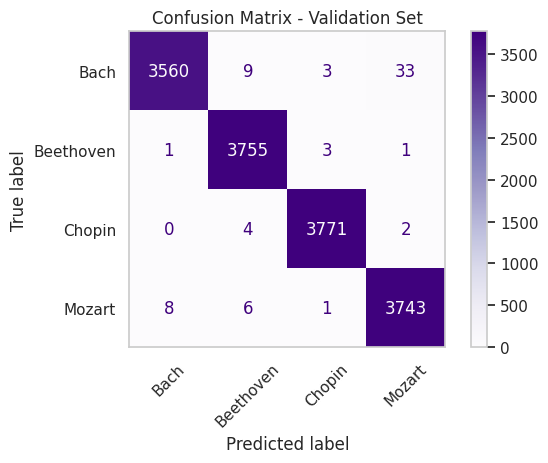

In [34]:
# Step 1: Predict on validation set
y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val, axis=1)

# Step 2: Compute confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred)
labels = composer_encoder.classes_

# Step 3: Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Purples', xticks_rotation=45, values_format='d')
plt.title('Confusion Matrix - Validation Set')
plt.grid(False)
plt.tight_layout()
plt.show()


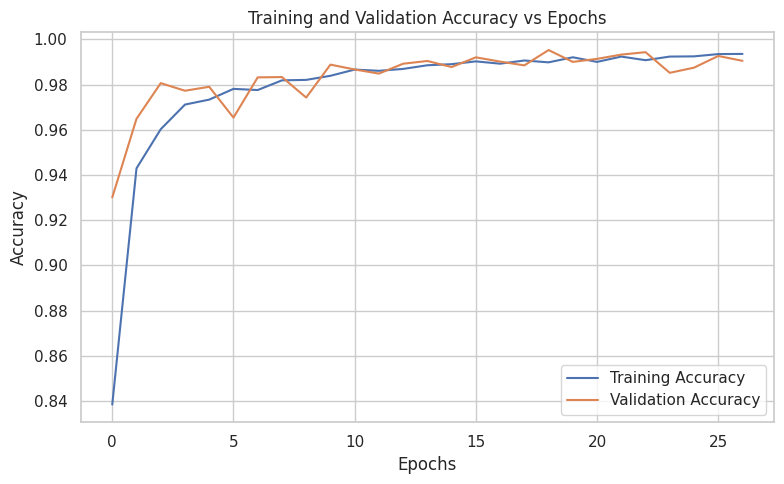

In [36]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Interpretation:

Fast initial learning

Training accuracy starts around 0.84, validation around 0.93 — meaning the model generalizes well even early on.

By epoch 3-5, both are above 0.96, which is very high already.

Validation slightly ahead of training early on

In the first ~10 epochs, validation accuracy is slightly higher than training.

This is not unusual — regularization (dropout, L2) and jittering can make the training set a bit harder, while validation benefits from a cleaner evaluation.

Near-perfect plateau

From about epoch 15 onwards, both curves hover around 0.99.

The gap between training and validation is minimal → this suggests no obvious overfitting.

High stability

The lines are smooth with only small fluctuations — the model has converged and is stable.

# Model Evaluation

In [37]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

311/311 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.9946 - loss: 0.0609
✅ Test Loss: 0.0605
✅ Test Accuracy: 0.9941


311/311 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2403
           1       0.99      1.00      1.00      2507
           2       1.00      1.00      1.00      2519
           3       0.99      0.99      0.99      2505

    accuracy                           0.99      9934
   macro avg       0.99      0.99      0.99      9934
weighted avg       0.99      0.99      0.99      9934



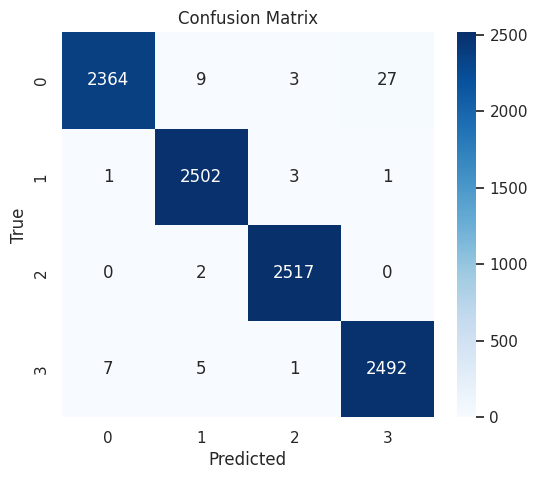

In [38]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [39]:
df_preds = pd.DataFrame({"Actual": y_true, "Predicted": y_pred})
df_preds.to_csv("test_predictions.csv", index=False)
